In [55]:
import pathlib
import datetime
import json
from collections import defaultdict
import pathlib
import os
import random

from readability import Readability
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import ollama
import numpy as np
from pydantic import BaseModel
from dotenv import load_dotenv
from openai import OpenAI

# Make matplotlib use dark theme
# plt.style.use('dark_background')

load_dotenv()

CWD = pathlib.Path("").parent

openai_client = OpenAI(
    api_key=os.getenv("OPENAI_API_KEY"),
)

try:
    _ = Readability('')
except:
    import nltk
    nltk.download('punkt_tab')

In [56]:
# Load the dataset
dfs = pd.read_excel('./data/accumulative_metrics_aggregated.xlsx', sheet_name=None)

In [57]:
# Preprocessing
assignment_names = ['Suffrage', 'GatesS', 'GatesT']
num_of_questions = [18, 15, 15]
gates_list = {
    'GatesS': ['Ants', 'Clouds', 'Waterclocks'],
    'GatesT': ['Lizards', 'Tastes', 'Lodgepoles']
}
all_dfs = []

# Keep only the top features
with open('handpicked_top_features.json', 'r') as f:
    top_features = json.load(f)['features']

print([x for x in top_features])

for i, assignment_name in enumerate(assignment_names):
    df = dfs[assignment_name]
    assignment_top_features = [f"{assignment_name}_{x}" for x in top_features]
    df = df[['id', f"{assignment_name}_score"] + assignment_top_features + [f"{assignment_name}_{j+1}" for j in range(num_of_questions[i])]]
    df['assignment'] = assignment_name

    # Remove assignment prefix
    df.columns = df.columns.str.replace(f"{assignment_name}_", '')

    # Drop nan
    df = df.dropna()

    # Set the 'id' as index
    all_dfs.append(df)

# Add student attributes and join via 'id
student_attributes = pd.read_excel('./data/student_attributes.xlsx')
all_dfs = [df.merge(student_attributes, on='id', how='left') for df in all_dfs]

# Drop disability data ('disability', and 'disability_type') and convert "Yes" and "No" in "ELL" to 1 and 0
for i in range(len(all_dfs)):
    df = all_dfs[i]
    df = df.drop(['disability', 'disability_type', 'home_language'], axis=1)
    df['ELL'] = df['ELL'].apply(lambda x: 1 if x == 'Yes' else 0)
    
    # Make the 'id' the index
    # df = df.set_index('id')

    # Store
    all_dfs[i] = df


# Show 'Suffrage' df
print(all_dfs[0].head())

['coldread_stopwatch_wpm', 'coldread_coverage_line_%', 'coldread_dwell_time_pdf', 'coldread_fix_dispersion_mean', 'coldread_saccade_regression_rate_%', 'qa_dwell_time_quiz', 'qa_dwell_time_pdf', 'qa_coverage_line_%', 'qa_fix_dispersion_mean', 'qa_saccade_regression_rate_%']
    id     score  coldread_stopwatch_wpm  coldread_coverage_line_%  \
0  103  0.666667                  215.03                     68.42   
1  104  0.444444                  108.22                     75.79   
2  108  0.444444                  161.03                     43.16   
3  109  0.388889                  255.51                     45.26   
4  115  0.500000                  182.79                     72.63   

   coldread_dwell_time_pdf  coldread_fix_dispersion_mean  \
0                   135.08                          2.35   
1                   183.95                          1.85   
2                    83.68                          3.07   
3                    58.47                          3.31   
4   

/tmp/ipykernel_1446325/747379133.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['assignment'] = assignment_name
/tmp/ipykernel_1446325/747379133.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['assignment'] = assignment_name
/tmp/ipykernel_1446325/747379133.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [58]:
# For each assignment, perform the same processing
score_distribution_dir = CWD / 'data' / 'output' / 'score_distribution'
os.makedirs(score_distribution_dir, exist_ok=True)
for assignment_name, df in zip(assignment_names, all_dfs):

    # Generate groups based on the mean and std thresholds and plot the distribution of the group scores
    mean = df['score'].mean()
    std = df['score'].std()
    high_threshold = mean + std/1.5
    low_threshold = mean - std/1.5

    # Create a new figure for each assignment
    plt.figure()

    # Plot the distribution of the scores
    sns.histplot(df['score'], kde=True)

    # Add the mean and median
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=1, label='Classroom Mean')

    # Add the thresholds
    plt.axvline(high_threshold, color='g', linestyle='dashed', linewidth=1)
    plt.axvline(low_threshold, color='g', linestyle='dashed', linewidth=1)

    # Plot the mean score for special groups (Disability and ELL)
    # ell_mean = df[df['ELL'] == 'Yes']['score'].mean()
    # plt.axvline(ell_mean, color='b', linestyle='dashed', linewidth=1, label='ELL Mean')

    # Add legend with the values
    plt.legend({
        f"KDE": None,
        f'Classroom Mean={mean:.2f}': mean,
        f'High Threshold={high_threshold:.2f}': high_threshold,
        f'Low Threshold={low_threshold:.2f}': low_threshold,
        # f'ELL Mean={ell_mean:.2f}': ell_mean
    })
    plt.title(f'{assignment_name} - Distribution of Scores')

    # Show the plot
    # plt.show()
    # Save the plot

    plt.savefig(str(score_distribution_dir / f'{assignment_name}.png'))
    plt.close()


Processing assignment: Suffrage...
Optimal K (from BIC) for Suffrage: 7


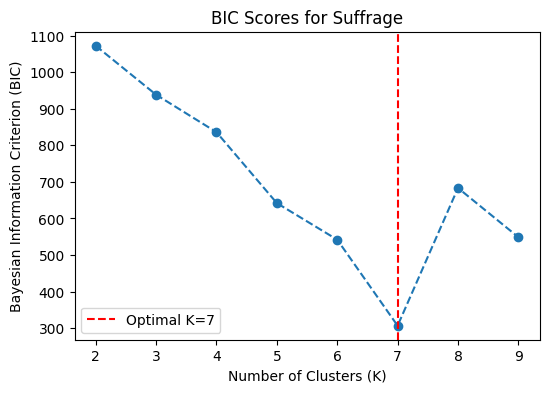

Avg Within-Cluster Variance (Suffrage): 0.512
Silhouette Score (Suffrage): 0.201
ANOVA Test Results for Suffrage:
                            statistic       p-value
coldread_stopwatch_wpm    102.113337  2.781932e-22
qa_dwell_time_pdf          26.540511  2.475463e-12
qa_coverage_line_%         20.681366  1.006014e-10
qa_fix_dispersion_mean     11.274229  2.838118e-07
coldread_coverage_line_%   10.306296  7.946941e-07


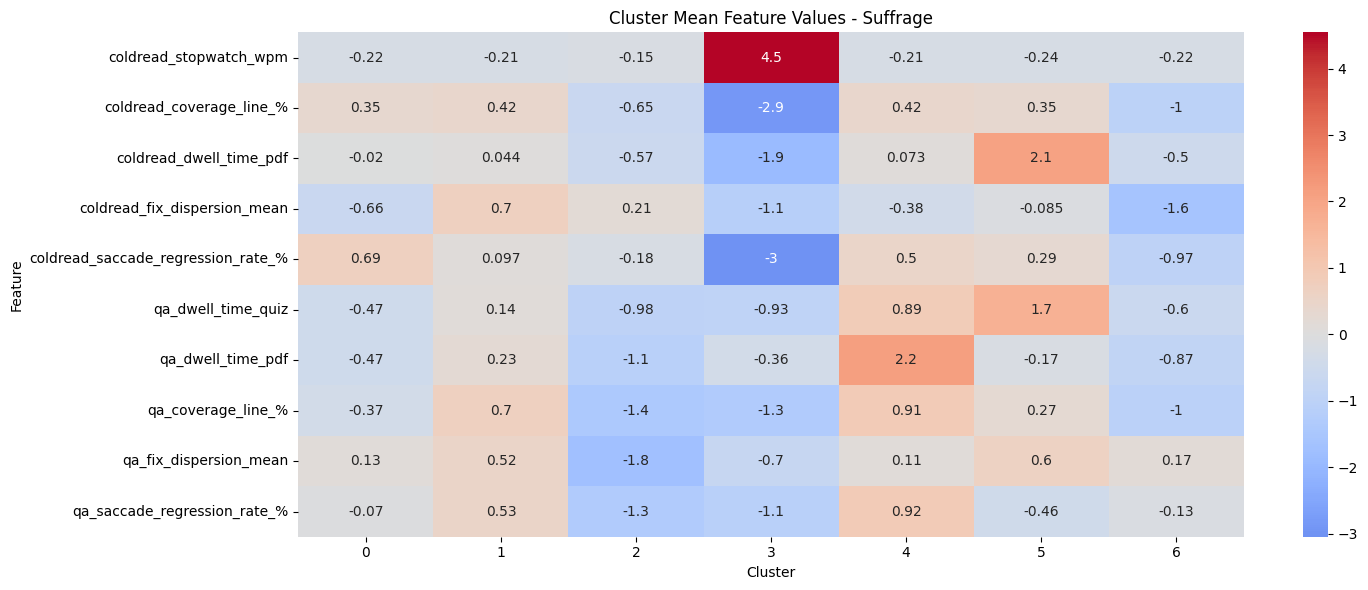


Processing assignment: GatesS...
Optimal K (from BIC) for GatesS: 9


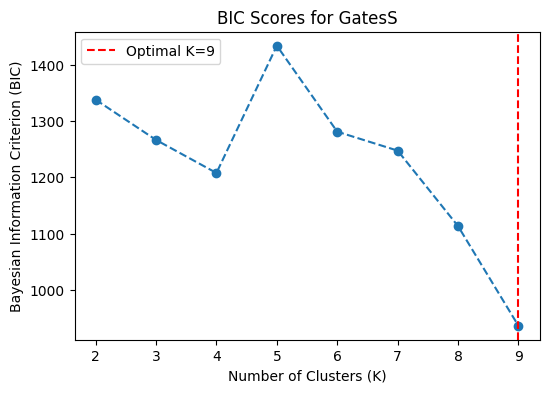

Avg Within-Cluster Variance (GatesS): 0.503
Silhouette Score (GatesS): 0.128
ANOVA Test Results for GatesS:
                                statistic       p-value
coldread_stopwatch_wpm        161.912639  5.497001e-28
qa_dwell_time_pdf              12.844849  6.213482e-09
qa_saccade_regression_rate_%   12.415706  9.841479e-09
qa_coverage_line_%             11.633444  2.339005e-08
coldread_dwell_time_pdf        10.924631  5.295153e-08


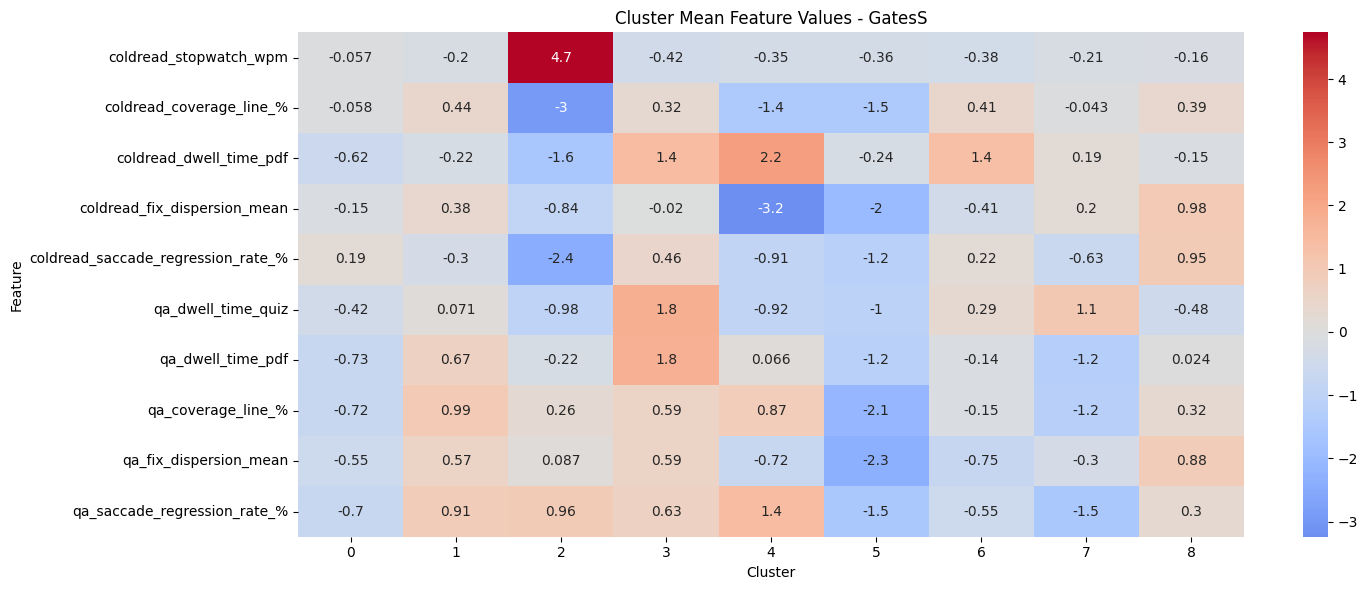


Processing assignment: GatesT...
Optimal K (from BIC) for GatesT: 9


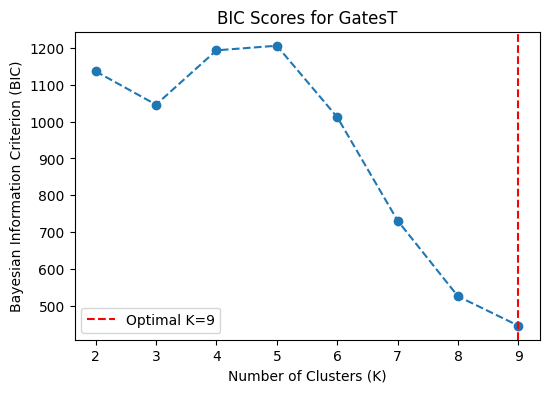

Avg Within-Cluster Variance (GatesT): 0.394
Silhouette Score (GatesT): 0.165
ANOVA Test Results for GatesT:
                                      statistic       p-value
coldread_stopwatch_wpm              105.352410  1.032691e-21
qa_dwell_time_pdf                    19.291587  1.495983e-10
qa_coverage_line_%                   16.116885  1.592433e-09
coldread_saccade_regression_rate_%   14.625904  5.468791e-09
qa_saccade_regression_rate_%         10.879741  1.910939e-07


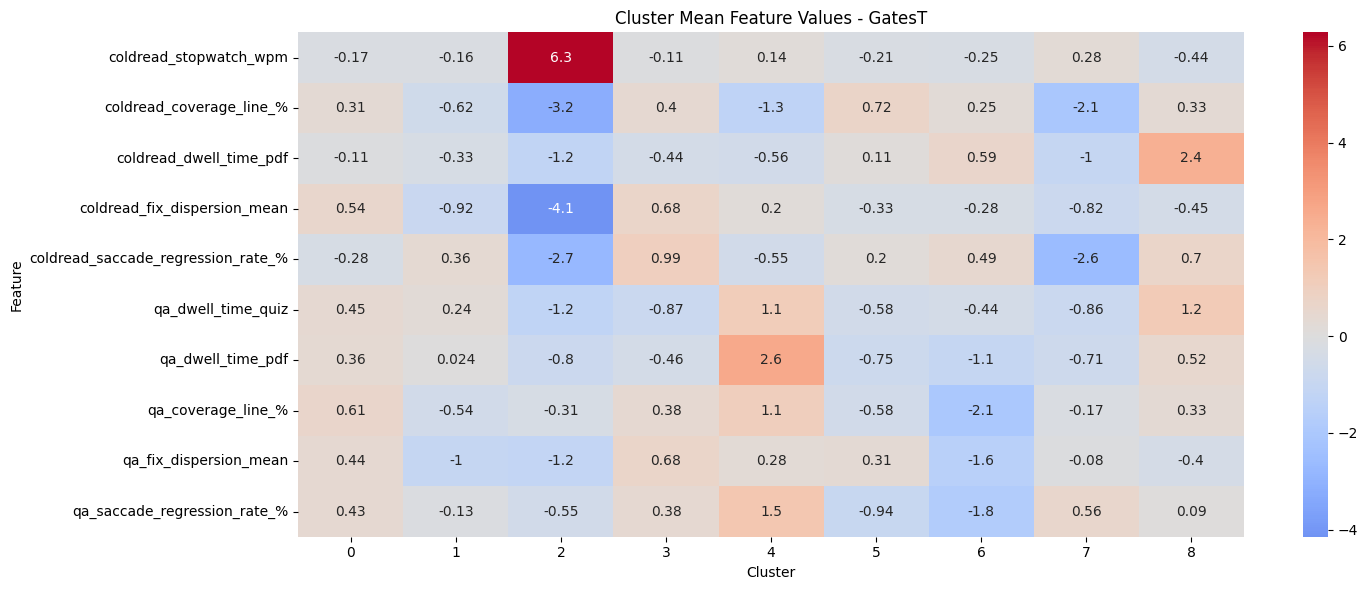

  Assignment  Optimal K  Avg Within-Cluster Variance  Silhouette Score  \
0   Suffrage          7                     0.511982          0.201380   
1     GatesS          9                     0.502713          0.127860   
2     GatesT          9                     0.394221          0.164998   

  Most Significant Feature (ANOVA)  Feature P-Value  
0           coldread_stopwatch_wpm     2.781932e-22  
1           coldread_stopwatch_wpm     5.497001e-28  
2           coldread_stopwatch_wpm     1.032691e-21  


In [87]:
# Gaussian Mixture Model (GMM) Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Define output directories
cluster_plots_dir = CWD / 'data' / 'output' / 'cluster_gmm'
os.makedirs(cluster_plots_dir, exist_ok=True)

cluster_metrics_results = []

for assignment_name, df in zip(assignment_names, all_dfs):
    print(f"\nProcessing assignment: {assignment_name}...")

    # Select features for clustering
    X = df[top_features].copy()

    # Standardize data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    ### 📌 Determine Optimal K Using Bayesian Information Criterion (BIC) ###
    bic_scores = []
    K_range = range(2, 10)  # Testing K from 2 to 9

    for k in K_range:
        gmm = GaussianMixture(n_components=k, random_state=42, covariance_type='full')
        gmm.fit(X_scaled)
        bic_scores.append(gmm.bic(X_scaled))

    # Find the "elbow" point in BIC
    optimal_k = np.argmin(bic_scores) + 2  # BIC prefers lower values
    print(f"Optimal K (from BIC) for {assignment_name}: {optimal_k}")

    # Plot BIC Scores
    plt.figure(figsize=(6, 4))
    plt.plot(K_range, bic_scores, marker="o", linestyle="--")
    plt.axvline(optimal_k, color="r", linestyle="--", label=f"Optimal K={optimal_k}")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Bayesian Information Criterion (BIC)")
    plt.title(f"BIC Scores for {assignment_name}")
    plt.legend()
    plt.savefig(str(cluster_plots_dir / f"{assignment_name}_bic.png"))
    plt.show()

    ### 📌 Run Gaussian Mixture Model (GMM) Clustering ###
    gmm = GaussianMixture(n_components=optimal_k, random_state=42, covariance_type='full')
    clusters_gmm = gmm.fit_predict(X_scaled)
    df["gmm_cluster"] = clusters_gmm

    # Compute within-cluster variance
    X_scaled_df = pd.DataFrame(X_scaled, columns=top_features)
    X_scaled_df["cluster"] = clusters_gmm

    cluster_variance = X_scaled_df.groupby("cluster")[top_features].var()
    avg_within_cluster_variance = cluster_variance.mean().mean()
    print(f"Avg Within-Cluster Variance ({assignment_name}): {avg_within_cluster_variance:.3f}")

    # Compute silhouette score
    if len(set(clusters_gmm)) > 1:  # Avoid silhouette error if only one cluster is found
        sil_score = silhouette_score(X_scaled, clusters_gmm)
    else:
        sil_score = np.nan
    print(f"Silhouette Score ({assignment_name}): {sil_score:.3f}")

    ### 📌 Compute ANOVA test for cluster distinctiveness ###
    anova_results = {}
    for feature in top_features:
        cluster_data = [X_scaled_df[X_scaled_df["cluster"] == i][feature] for i in range(optimal_k)]
        stat, p_value = stats.f_oneway(*cluster_data)
        anova_results[feature] = {"statistic": stat, "p-value": p_value}

    # Convert ANOVA results to DataFrame and sort by p-value
    anova_df = pd.DataFrame(anova_results).T.sort_values(by="p-value")
    print(f"ANOVA Test Results for {assignment_name}:\n", anova_df.head())

    # Save clustering metrics
    cluster_metrics_results.append({
        "Assignment": assignment_name,
        "Optimal K": optimal_k,
        "Avg Within-Cluster Variance": avg_within_cluster_variance,
        "Silhouette Score": sil_score,
        "Most Significant Feature (ANOVA)": anova_df.index[0] if not anova_df.empty else "N/A",
        "Feature P-Value": anova_df.iloc[0]["p-value"] if not anova_df.empty else "N/A"
    })

    ### 📌 Plot Heatmap of Cluster Mean Feature Values ###
    cluster_summary = X_scaled_df.groupby("cluster")[top_features].mean()

    plt.figure(figsize=(15, 6))
    sns.heatmap(cluster_summary.T, cmap="coolwarm", center=0, annot=True)
    plt.title(f"Cluster Mean Feature Values - {assignment_name}")
    plt.xlabel("Cluster")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig(str(cluster_plots_dir / f"{assignment_name}_heatmap.png"))
    plt.show()

# Convert clustering metrics to DataFrame
cluster_metrics_df = pd.DataFrame(cluster_metrics_results)
cluster_metrics_df.to_excel(CWD / 'data' / 'output' / 'cluster_metrics_gmm.xlsx', index=False)
print(cluster_metrics_df.head())


Cophenetic Correlation Coefficient: 0.6572707835815297


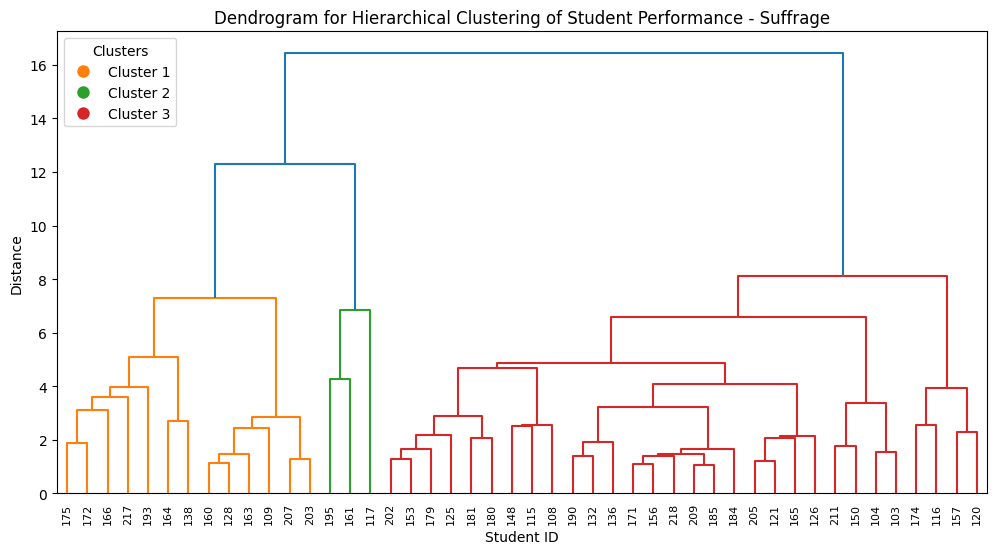

Average Within-Cluster Variance: 0.9383790318250099
ANOVA Test results for Suffrage:
                               statistic   p-value
qa_saccade_regression_rate_%   1.847235  0.169967
qa_dwell_time_pdf              1.143971  0.328055
coldread_coverage_line_%       1.069187  0.352237
qa_dwell_time_quiz             0.971787  0.386561
qa_coverage_line_%             0.683505  0.510244


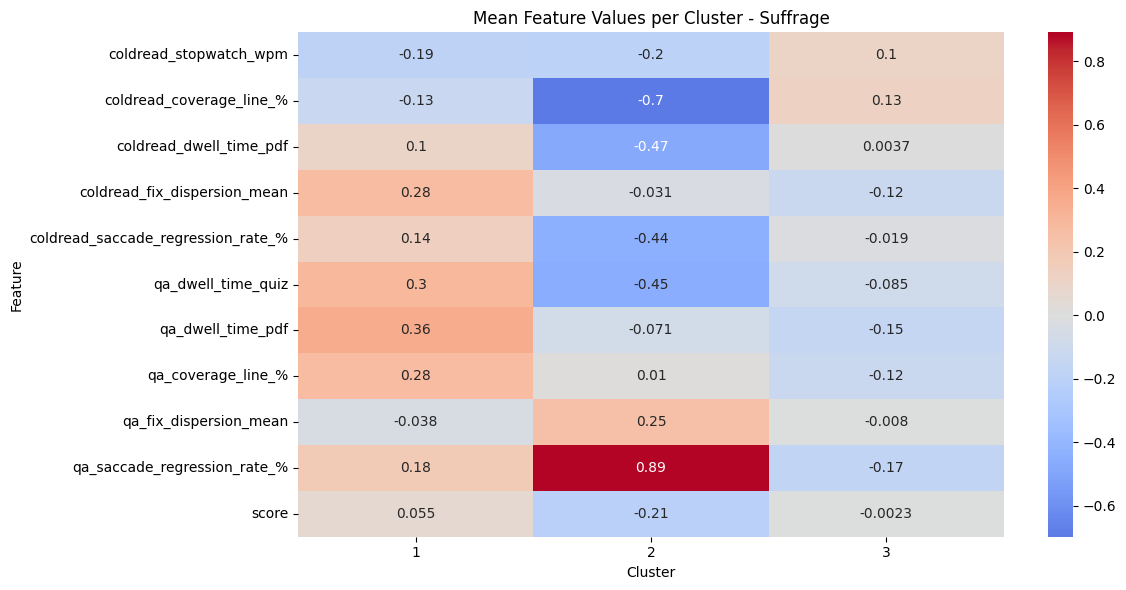

Cophenetic Correlation Coefficient: 0.5215754474682202


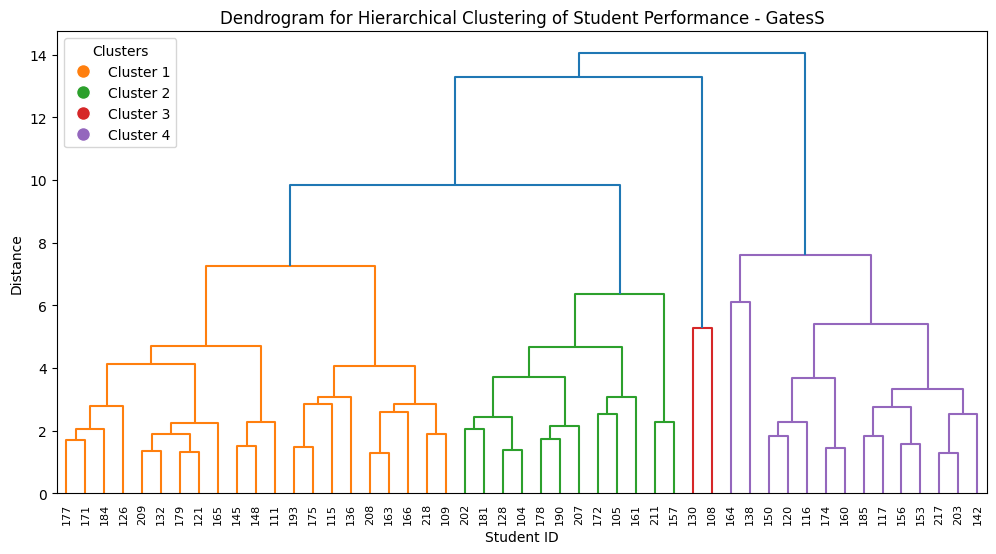

Average Within-Cluster Variance: 0.9462945208793749
ANOVA Test results for GatesS:
                               statistic   p-value
qa_dwell_time_quiz             1.330723  0.276220
qa_saccade_regression_rate_%   1.018177  0.393528
qa_dwell_time_pdf              0.600449  0.618072
qa_coverage_line_%             0.542771  0.655518
coldread_fix_dispersion_mean   0.509114  0.678011


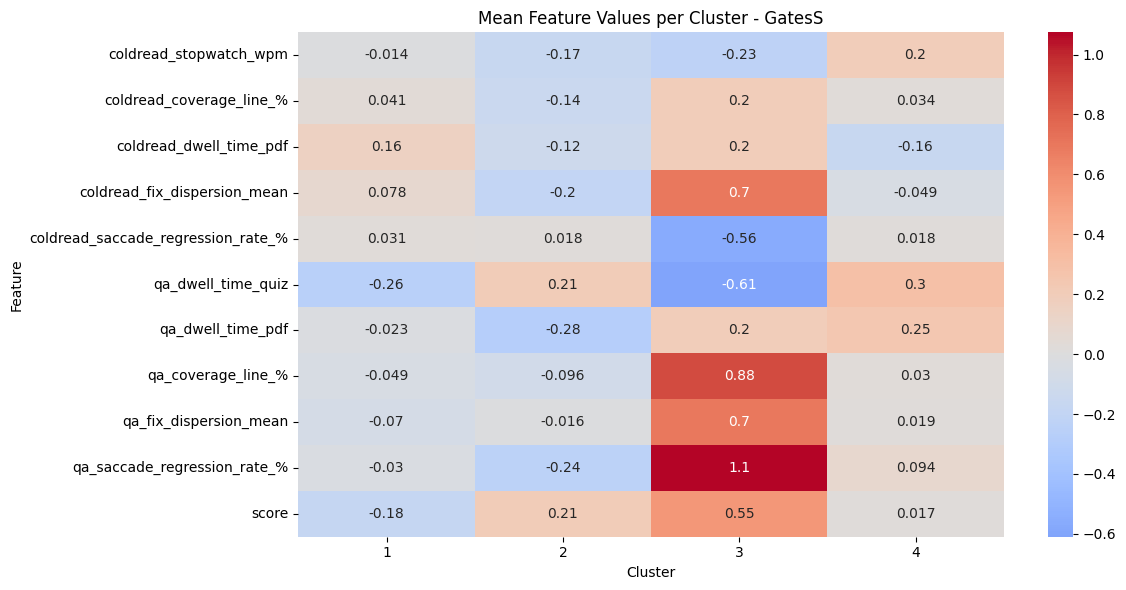

Cophenetic Correlation Coefficient: 0.5091764779997477


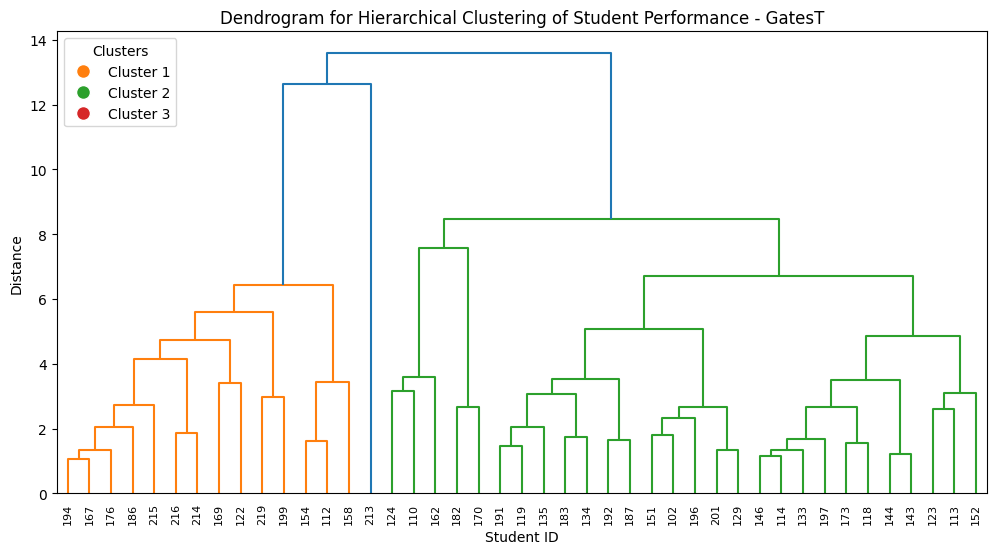

Average Within-Cluster Variance: 0.9486087453773209
ANOVA Test results for GatesT:
                                     statistic   p-value
qa_dwell_time_pdf                    2.442603  0.099801
qa_coverage_line_%                   1.991029  0.149861
qa_dwell_time_quiz                   1.921926  0.159597
coldread_fix_dispersion_mean         1.350281  0.270725
coldread_saccade_regression_rate_%   1.015113  0.371506


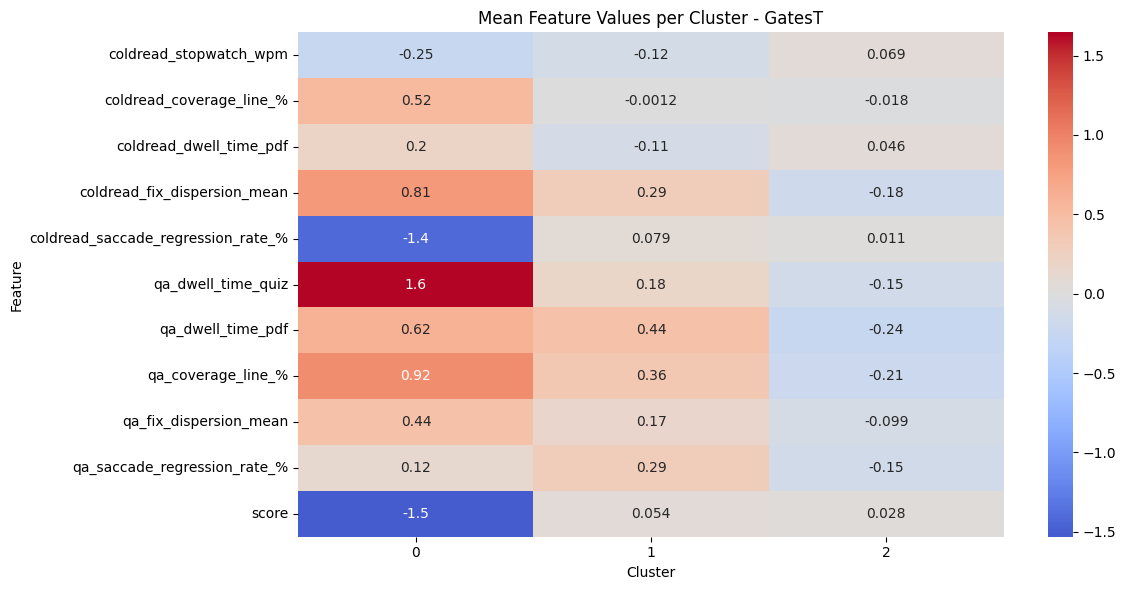

,Assignment,Cophenetic Correlation,Avg Within-Cluster Variance,Silhouette Score,Most Significant Feature (ANOVA),Feature P-Value
0,Suffrage,0.657271,0.938379,-0.069966,qa_saccade_regression_rate_%,1.70e-01
1,GatesS,0.521575,0.946295,-0.133443,qa_dwell_time_quiz,2.76e-01
2,GatesT,0.509176,0.948609,-0.126542,qa_dwell_time_pdf,9.98e-02


In [88]:
# Dendrogram Clustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy import stats
from sklearn.metrics import silhouette_score

cluster_plots_dir = CWD / 'data' / 'output' / 'cluster_dendrogram'
os.makedirs(cluster_plots_dir, exist_ok=True)


cluster_metrics_results = []
for assignment_name, df in zip(assignment_names, all_dfs):

    # Perform unsupervised clustering to identify groups of student
    # X = df[[f"{assignment_name}_{x}" for x in top_features] + [f"{assignment_name}_score", "valor_MAP", 'ELL']]
    X = df[top_features]

    # Select features for clustering (excluding student ID)
    features_for_clustering = X.copy()  # Use all relevant features

    # Normalize data (Hierarchical Clustering is distance-based, so we need to standardize)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features_for_clustering)

    # # Only make the behavior data available
    # X_scaled = X_scaled[:, :-2]

    # Compute hierarchical clustering linkage matrix
    Z = hierarchy.linkage(X_scaled, method="ward")  # Ward's method minimizes variance within clusters
    # print(Z)

    # Compute the cophenetic correlation coefficient to evaluate the clustering
    c, coph_dists = hierarchy.cophenet(Z, pdist(X_scaled))
    print(f"Cophenetic Correlation Coefficient: {c}")

    # Plot the dendrogram to visualize the hierarchy
    plt.figure(figsize=(12, 6))
    dn = hierarchy.dendrogram(Z, labels=df['id'].values, orientation="top", distance_sort="descending")

    # Extract unique colors used in the dendrogram
    clusters = list(set(dn['leaves_color_list']))
    cluster_colors = np.array([[255,127,14,255],[44,160,44,255],[214,39,40,255],[148,103,189,255],[140,86,75,255]])/255
    cluster_ids = [int(x[1]) for x in clusters]

    # Create a legend mapping colors to cluster IDs
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {i+1}', 
                                markerfacecolor=cluster_colors[i], markersize=10) for i in range(len(clusters))]

    plt.legend(handles=legend_handles, title="Clusters", loc="upper left")
    plt.title(f"Dendrogram for Hierarchical Clustering of Student Performance - {assignment_name}")
    plt.xlabel("Student ID")
    plt.ylabel("Distance")
    plt.savefig(str(cluster_plots_dir / f'{assignment_name}.png'))
    plt.show()

    # # Assign clusters to each student
    # # Convert the scaled data back to a DataFrame
    X_scaled_df = pd.DataFrame(X_scaled, columns=features_for_clustering.columns)

    # Obtain the clusters from the dendrogram without computing again
    leaves_color_list = dn['leaves_color_list']
    # Convert from "C0", "C1", "C2" to 0, 1, 2 and assign as the Cluster column
    X_scaled_df["Cluster"] = [int(x[1]) for x in leaves_color_list]

    # Compute within-cluster variance
    cluster_variances = X_scaled_df.groupby("Cluster").var()
    avg_within_cluster_variance = cluster_variances.mean().mean()
    print(f"Average Within-Cluster Variance: {avg_within_cluster_variance}")

    # Compute cluster Distinctiveness (ANOVA Test)
    anova_results = {}
    for feature in top_features:
        # cluster_data = [X_scaled_df[X_scaled_df["Cluster"] == i][feature] for i in range(len(clusters))]
        cluster_data = [X_scaled_df[X_scaled_df["Cluster"] == i][feature] for i in cluster_ids]
        stat, p_value = stats.f_oneway(*cluster_data)
        anova_results[feature] = {"statistic": stat, "p-value": p_value}

    # Convert ANOVAs to DataFrame
    anova_df = pd.DataFrame(anova_results).T
    anova_df = anova_df.sort_values(by='p-value')
    print(f"ANOVA Test results for {assignment_name}:\n", anova_df.head())

    # Compute silhouette score
    sil_score = silhouette_score(X_scaled, X_scaled_df["Cluster"].values)

    # Save results for overall table
    cluster_metrics_results.append({
        "Assignment": assignment_name,
        "Cophenetic Correlation": c,
        "Avg Within-Cluster Variance": avg_within_cluster_variance,
        "Silhouette Score": sil_score,
        "Most Significant Feature (ANOVA)": anova_df.index[0] if not anova_df.empty else "N/A",
        "Feature P-Value": anova_df.iloc[0]['p-value'] if not anova_df.empty else "N/A"
    })

    # Add back the performance metrics (score and MAP)
    X_scaled_df[f"score"] = df[f"score"]

    # Normalize the performance metrics for visualization
    X_scaled_df[f"score"] = scaler.fit_transform(X_scaled_df[[f"score"]])

    # Print out the size of the clusters
    cluster_sizes = X_scaled_df['Cluster'].value_counts().sort_index()

    # Compute mean feature values per cluster
    cluster_summary = X_scaled_df.groupby("Cluster").mean()

    # Prinout the score and MAP mean per cluster in a non-normalized way
    score_map_summary = X_scaled_df.groupby("Cluster")[["score"]].mean()
    # print(score_map_summary)

    # Prinout the size of the clusters
    # print(cluster_sizes)

    # Plot the mean feature values per cluster
    plt.figure(figsize=(12, 6))
    sns.heatmap(cluster_summary.T, cmap="coolwarm", center=0, annot=True)
    plt.title(f"Mean Feature Values per Cluster - {assignment_name}")
    plt.xlabel("Cluster")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig(str(cluster_plots_dir / f'{assignment_name}_heatmap.png'))
    plt.show()

    # Assign the cluster to the original dataframe
    df['dendrogram_cluster'] = X_scaled_df['Cluster']
    # break

# Convert cluster quality metrics to DataFrame
cluster_metrics_df = pd.DataFrame(cluster_metrics_results)
# cluster_metrics_df = cluster_metrics_df.round(3)
cluster_metrics_df['Feature P-Value'] = cluster_metrics_df['Feature P-Value'].apply(lambda x: f"{x:.2e}" if x != "N/A" else x)
cluster_metrics_df.to_excel(CWD / 'data' / 'output' / 'cluster_metrics_dendrogram.xlsx', index=False)
cluster_metrics_df.head()


Processing assignment: Suffrage...
Selected `eps` for Suffrage: 3.085


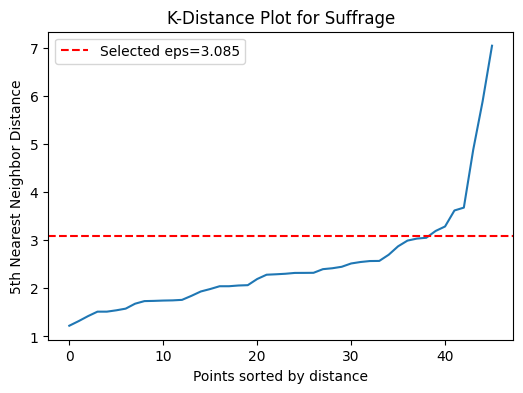

Selected `min_samples` for Suffrage: 3
Number of clusters found for Suffrage: 1
Re-running DBSCAN with lower `eps` = 2.665
Avg Within-Cluster Variance (Suffrage): 0.370
Silhouette Score (Suffrage): 0.320
ANOVA Test Results for Suffrage:
                                     statistic  p-value
coldread_stopwatch_wpm                    NaN      NaN
coldread_coverage_line_%                  NaN      NaN
coldread_dwell_time_pdf                   NaN      NaN
coldread_fix_dispersion_mean              NaN      NaN
coldread_saccade_regression_rate_%        NaN      NaN


/home/nicole/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


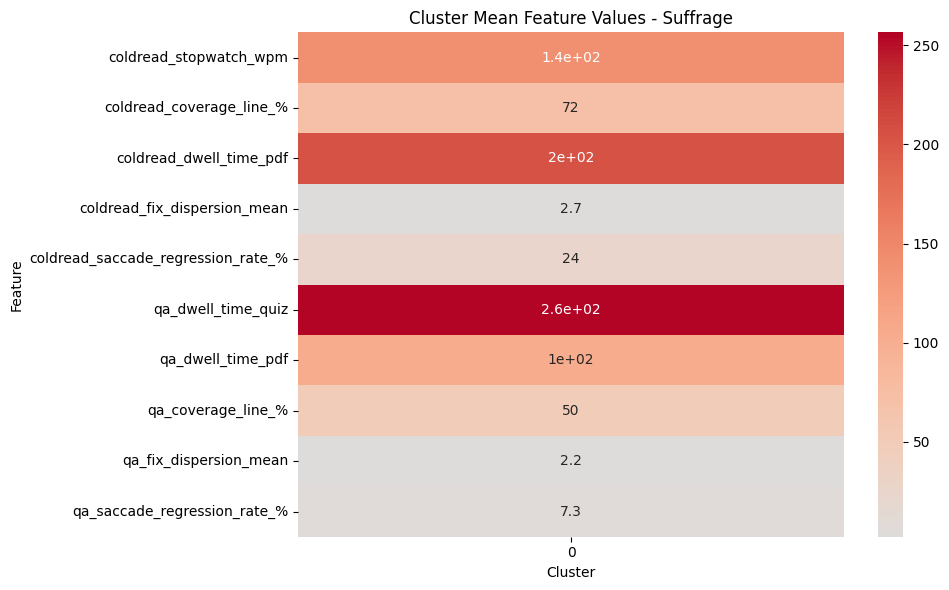


Processing assignment: GatesS...
Selected `eps` for GatesS: 2.858


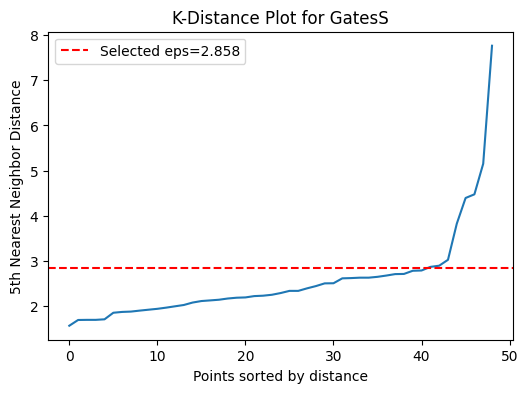

Selected `min_samples` for GatesS: 3
Number of clusters found for GatesS: 1
Re-running DBSCAN with lower `eps` = 2.682
Avg Within-Cluster Variance (GatesS): nan
Silhouette Score (GatesS): nan
ANOVA Test Results for GatesS:
 Empty DataFrame
Columns: [statistic, p-value]
Index: []

Processing assignment: GatesT...
Selected `eps` for GatesT: 3.325


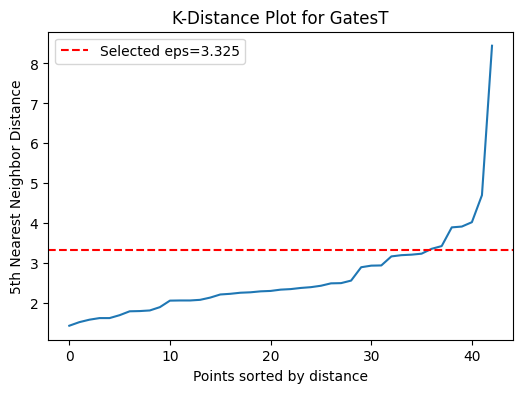

Selected `min_samples` for GatesT: 3
Number of clusters found for GatesT: 1
Re-running DBSCAN with lower `eps` = 3.059
Avg Within-Cluster Variance (GatesT): nan
Silhouette Score (GatesT): nan
ANOVA Test Results for GatesT:
 Empty DataFrame
Columns: [statistic, p-value]
Index: []
  Assignment  Number of Clusters  Avg Within-Cluster Variance  \
0   Suffrage                   2                     0.369886   
1     GatesS                   1                          NaN   
2     GatesT                   1                          NaN   

   Silhouette Score Most Significant Feature (ANOVA) Feature P-Value  
0          0.320452           coldread_stopwatch_wpm             nan  
1               NaN                              N/A             N/A  
2               NaN                              N/A             N/A  


In [89]:
# DBSCAN Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Define output directories
cluster_plots_dir = CWD / 'data' / 'output' / 'cluster_dbscan'
os.makedirs(cluster_plots_dir, exist_ok=True)

cluster_metrics_results = []

for assignment_name, df in zip(assignment_names, all_dfs):
    print(f"\nProcessing assignment: {assignment_name}...")

    # Select features for clustering
    X = df[top_features].copy()

    # Standardize data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    ### 📌 Optimize `eps` using K-Distance Plot ###
    nearest_neighbors = NearestNeighbors(n_neighbors=5)
    nearest_neighbors.fit(X_scaled)
    distances, indices = nearest_neighbors.kneighbors(X_scaled)

    # Sort distances for k-distance plot
    distances = np.sort(distances[:, 4], axis=0)

    # Find knee/elbow point
    eps_value = np.percentile(distances, 85)  # Adjust based on dataset structure
    print(f"Selected `eps` for {assignment_name}: {eps_value:.3f}")

    # Plot K-Distance Graph
    plt.figure(figsize=(6, 4))
    plt.plot(distances)
    plt.axhline(y=eps_value, color="r", linestyle="--", label=f"Selected eps={eps_value:.3f}")
    plt.xlabel("Points sorted by distance")
    plt.ylabel("5th Nearest Neighbor Distance")
    plt.title(f"K-Distance Plot for {assignment_name}")
    plt.legend()
    plt.savefig(str(cluster_plots_dir / f"{assignment_name}_kdistance.png"))
    plt.show()

    ### 📌 Optimize `min_samples` Based on Dataset Size ###
    min_samples_value = max(3, int(0.02 * len(X)))  # 2% of dataset or at least 3
    print(f"Selected `min_samples` for {assignment_name}: {min_samples_value}")

    ### 📌 Run DBSCAN Clustering with Optimized `eps` & `min_samples` ###
    dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
    clusters_dbscan = dbscan.fit_predict(X_scaled)
    df["cluster"] = clusters_dbscan

    # Count number of clusters (excluding noise points labeled -1)
    num_clusters = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)
    print(f"Number of clusters found for {assignment_name}: {num_clusters}")

    # If only 1 cluster was found, reduce `eps` and re-run DBSCAN
    if num_clusters <= 1:
        eps_value = np.percentile(distances, 75)  # Lower `eps` to force separation
        print(f"Re-running DBSCAN with lower `eps` = {eps_value:.3f}")
        dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
        clusters_dbscan = dbscan.fit_predict(X_scaled)
        df["dbscan_cluster"] = clusters_dbscan
        num_clusters = len(set(clusters_dbscan)) - (1 if -1 in clusters_dbscan else 0)

    # Compute within-cluster variance only if valid clusters exist
    if num_clusters > 1:
        X_scaled_df = pd.DataFrame(X_scaled, columns=top_features)
        X_scaled_df["cluster"] = clusters_dbscan
        cluster_variance = X_scaled_df[X_scaled_df["cluster"] != -1].groupby("cluster")[top_features].var()
        avg_within_cluster_variance = cluster_variance.mean().mean()
    else:
        avg_within_cluster_variance = np.nan  # No valid clusters

    print(f"Avg Within-Cluster Variance ({assignment_name}): {avg_within_cluster_variance:.3f}")

    # Compute silhouette score (only if valid clusters exist)
    if num_clusters > 1:
        sil_score = silhouette_score(X_scaled, clusters_dbscan)
    else:
        sil_score = np.nan  # No valid silhouette score

    print(f"Silhouette Score ({assignment_name}): {sil_score:.3f}")

    ### 📌 Compute ANOVA test for cluster distinctiveness ###
    anova_results = {}
    if num_clusters > 1:
        for feature in top_features:
            cluster_data = [df[df["cluster"] == i][feature] for i in range(num_clusters)]
            stat, p_value = stats.f_oneway(*cluster_data)
            anova_results[feature] = {"statistic": stat, "p-value": p_value}

        # Convert ANOVA results to DataFrame and sort by p-value
        anova_df = pd.DataFrame(anova_results).T.sort_values(by="p-value")
    else:
        anova_df = pd.DataFrame(columns=["statistic", "p-value"])

    print(f"ANOVA Test Results for {assignment_name}:\n", anova_df.head())

    # Save clustering metrics
    cluster_metrics_results.append({
        "Assignment": assignment_name,
        "Number of Clusters": num_clusters,
        "Avg Within-Cluster Variance": avg_within_cluster_variance,
        "Silhouette Score": sil_score,
        "Most Significant Feature (ANOVA)": anova_df.index[0] if not anova_df.empty else "N/A",
        "Feature P-Value": anova_df.iloc[0]["p-value"] if not anova_df.empty else "N/A"
    })

    ### 📌 Plot Heatmap of Cluster Mean Feature Values (Excluding Noise) ###
    if num_clusters > 1:
        cluster_summary = df[df["cluster"] != -1].groupby("cluster")[top_features].mean()

        plt.figure(figsize=(10, 6))
        sns.heatmap(cluster_summary.T, cmap="coolwarm", center=0, annot=True)
        plt.title(f"Cluster Mean Feature Values - {assignment_name}")
        plt.xlabel("Cluster")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.savefig(str(cluster_plots_dir / f"{assignment_name}_heatmap.png"))
        plt.show()

# Convert clustering metrics to DataFrame
cluster_metrics_df = pd.DataFrame(cluster_metrics_results)
cluster_metrics_df['Feature P-Value'] = cluster_metrics_df['Feature P-Value'].apply(lambda x: f"{x:.2e}" if x != "N/A" else x)
cluster_metrics_df.to_excel(CWD / 'data' / 'output' / 'cluster_metrics_dbscan.xlsx', index=False)
print(cluster_metrics_df.head())


Processing assignment: Suffrage...
Optimal K (from eigenvalues) for Suffrage: 8
Avg Within-Cluster Variance (Suffrage): 0.528
Silhouette Score (Suffrage): 0.175
ANOVA Test Results for Suffrage:
                                     statistic       p-value
qa_saccade_regression_rate_%        30.202228  1.188674e-13
qa_coverage_line_%                  21.503401  2.107070e-11
qa_fix_dispersion_mean              15.627039  1.908262e-09
coldread_saccade_regression_rate_%  14.450703  5.420131e-09
qa_dwell_time_pdf                   13.136277  1.867528e-08


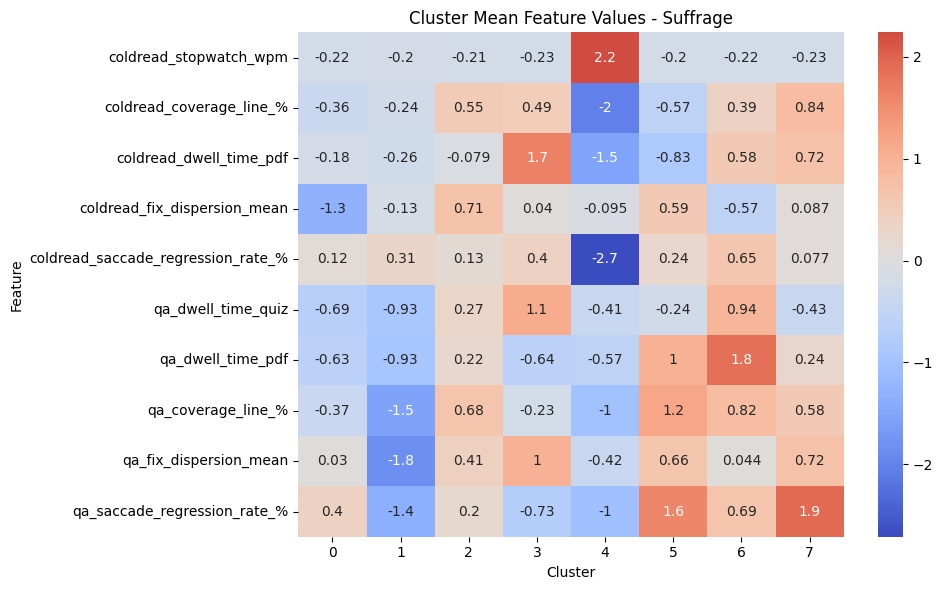


Processing assignment: GatesS...
Optimal K (from eigenvalues) for GatesS: 10
Avg Within-Cluster Variance (GatesS): 0.466
Silhouette Score (GatesS): 0.134
ANOVA Test Results for GatesS:
                                statistic       p-value
coldread_stopwatch_wpm        135.164994  1.469951e-26
qa_coverage_line_%             20.677680  3.125074e-12
qa_fix_dispersion_mean         15.638034  2.103596e-10
qa_saccade_regression_rate_%   13.890806  1.148150e-09
qa_dwell_time_pdf              11.561879  1.417626e-08


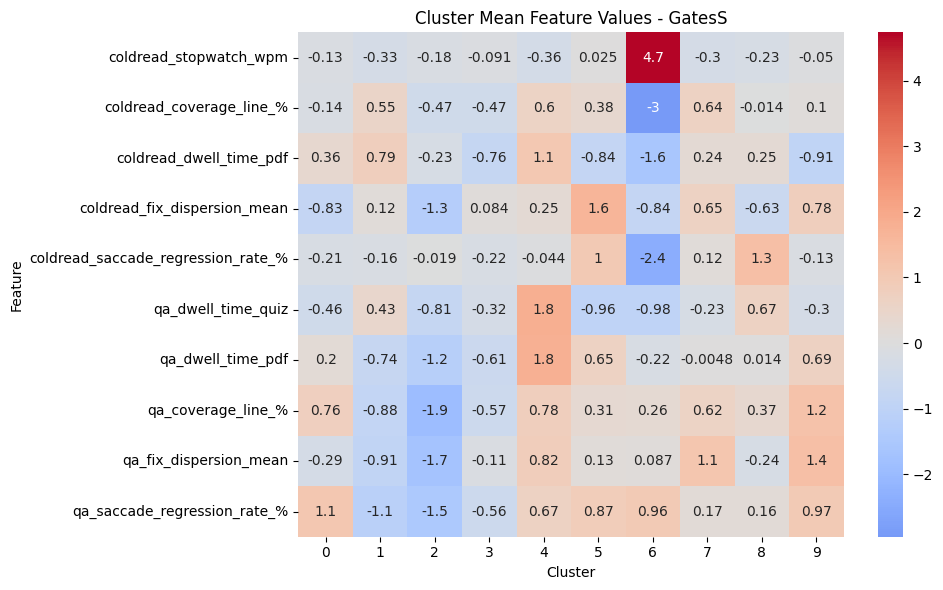


Processing assignment: GatesT...
Optimal K (from eigenvalues) for GatesT: 8
Avg Within-Cluster Variance (GatesT): 0.580
Silhouette Score (GatesT): 0.131
ANOVA Test Results for GatesT:
                                     statistic       p-value
qa_coverage_line_%                  16.158190  2.821335e-09
qa_dwell_time_pdf                   16.105508  2.941867e-09
coldread_saccade_regression_rate_%  14.986028  7.330908e-09
coldread_coverage_line_%            11.917914  1.172483e-07
qa_saccade_regression_rate_%        10.114254  7.491427e-07


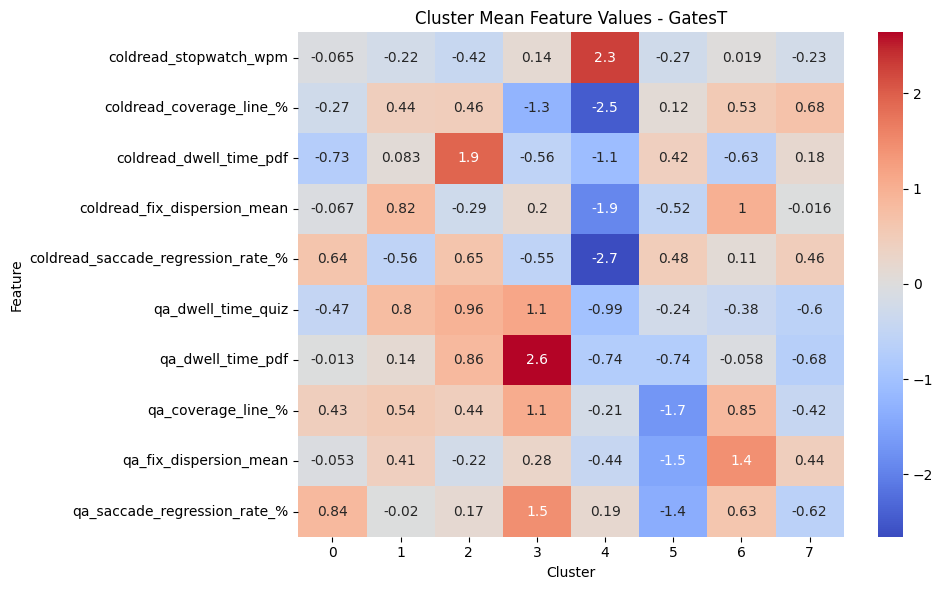

  Assignment  Optimal K  Avg Within-Cluster Variance  Silhouette Score  \
0   Suffrage          8                     0.528136          0.175309   
1     GatesS         10                     0.465781          0.134109   
2     GatesT          8                     0.580471          0.131371   

  Most Significant Feature (ANOVA) Feature P-Value  
0     qa_saccade_regression_rate_%        1.19e-13  
1           coldread_stopwatch_wpm        1.47e-26  
2               qa_coverage_line_%        2.82e-09  


In [90]:
# Spectral Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Define output directories
cluster_plots_dir = CWD / 'data' / 'output' / 'cluster_spectral'
os.makedirs(cluster_plots_dir, exist_ok=True)

cluster_metrics_results = []

for assignment_name, df in zip(assignment_names, all_dfs):
    print(f"\nProcessing assignment: {assignment_name}...")

    # Select features for clustering
    X = df[top_features].copy()

    # Standardize data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    ### 📌 Determine Optimal K Using Eigenvalues ###
    from sklearn.neighbors import kneighbors_graph
    from scipy.sparse.linalg import eigsh

    # Create a similarity graph
    similarity_graph = kneighbors_graph(X_scaled, n_neighbors=10, mode="connectivity", include_self=True)
    
    # Compute eigenvalues to estimate number of clusters
    eigenvalues, _ = eigsh(similarity_graph.asfptype(), k=10, which="LM")
    eigenvalue_gaps = np.diff(eigenvalues[::-1])
    optimal_k = np.argmax(eigenvalue_gaps) + 2  # Finding elbow point in eigenvalues
    print(f"Optimal K (from eigenvalues) for {assignment_name}: {optimal_k}")

    ### 📌 Run Spectral Clustering ###
    spectral = SpectralClustering(n_clusters=optimal_k, affinity="nearest_neighbors", random_state=42, assign_labels="kmeans")
    clusters_spectral = spectral.fit_predict(X_scaled)
    df["spectral_cluster"] = clusters_spectral

    # Compute within-cluster variance
    X_scaled_df = pd.DataFrame(X_scaled, columns=top_features)
    X_scaled_df["cluster"] = clusters_spectral

    cluster_variance = X_scaled_df.groupby("cluster")[top_features].var()
    avg_within_cluster_variance = cluster_variance.mean().mean()
    print(f"Avg Within-Cluster Variance ({assignment_name}): {avg_within_cluster_variance:.3f}")

    # Compute silhouette score
    if len(set(clusters_spectral)) > 1:  # Avoid silhouette error if only one cluster is found
        sil_score = silhouette_score(X_scaled, clusters_spectral)
    else:
        sil_score = np.nan
    print(f"Silhouette Score ({assignment_name}): {sil_score:.3f}")

    ### 📌 Compute ANOVA test for cluster distinctiveness ###
    anova_results = {}
    for feature in top_features:
        cluster_data = [X_scaled_df[X_scaled_df["cluster"] == i][feature] for i in range(optimal_k)]
        stat, p_value = stats.f_oneway(*cluster_data)
        anova_results[feature] = {"statistic": stat, "p-value": p_value}

    # Convert ANOVA results to DataFrame and sort by p-value
    anova_df = pd.DataFrame(anova_results).T.sort_values(by="p-value")
    print(f"ANOVA Test Results for {assignment_name}:\n", anova_df.head())

    # Save clustering metrics
    cluster_metrics_results.append({
        "Assignment": assignment_name,
        "Optimal K": optimal_k,
        "Avg Within-Cluster Variance": avg_within_cluster_variance,
        "Silhouette Score": sil_score,
        "Most Significant Feature (ANOVA)": anova_df.index[0] if not anova_df.empty else "N/A",
        "Feature P-Value": anova_df.iloc[0]["p-value"] if not anova_df.empty else "N/A"
    })

    ### 📌 Plot Heatmap of Cluster Mean Feature Values ###
    cluster_summary = X_scaled_df.groupby("cluster")[top_features].mean()

    plt.figure(figsize=(10, 6))
    sns.heatmap(cluster_summary.T, cmap="coolwarm", center=0, annot=True)
    plt.title(f"Cluster Mean Feature Values - {assignment_name}")
    plt.xlabel("Cluster")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig(str(cluster_plots_dir / f"{assignment_name}_heatmap.png"))
    plt.show()

# Convert clustering metrics to DataFrame
cluster_metrics_df = pd.DataFrame(cluster_metrics_results)
cluster_metrics_df['Feature P-Value'] = cluster_metrics_df['Feature P-Value'].apply(lambda x: f"{x:.2e}" if x != "N/A" else x)
cluster_metrics_df.to_excel(CWD / 'data' / 'output' / 'cluster_metrics_spectral.xlsx', index=False)
print(cluster_metrics_df.head())



Processing assignment: Suffrage...
Optimal K for Suffrage: 3


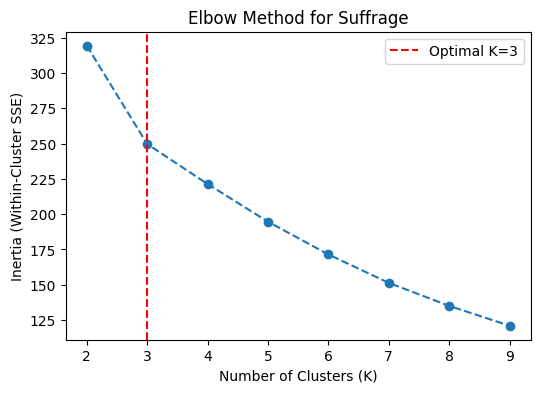

Avg Within-Cluster Variance (Suffrage): 0.912
Silhouette Score (Suffrage): 0.304
ANOVA Test Results for Suffrage:
                                     statistic       p-value
qa_coverage_line_%                  72.036124  1.867972e-14
coldread_stopwatch_wpm              40.349353  1.360570e-10
coldread_coverage_line_%            37.167024  4.235987e-10
coldread_saccade_regression_rate_%  32.674562  2.348689e-09
qa_saccade_regression_rate_%        14.696913  1.367694e-05


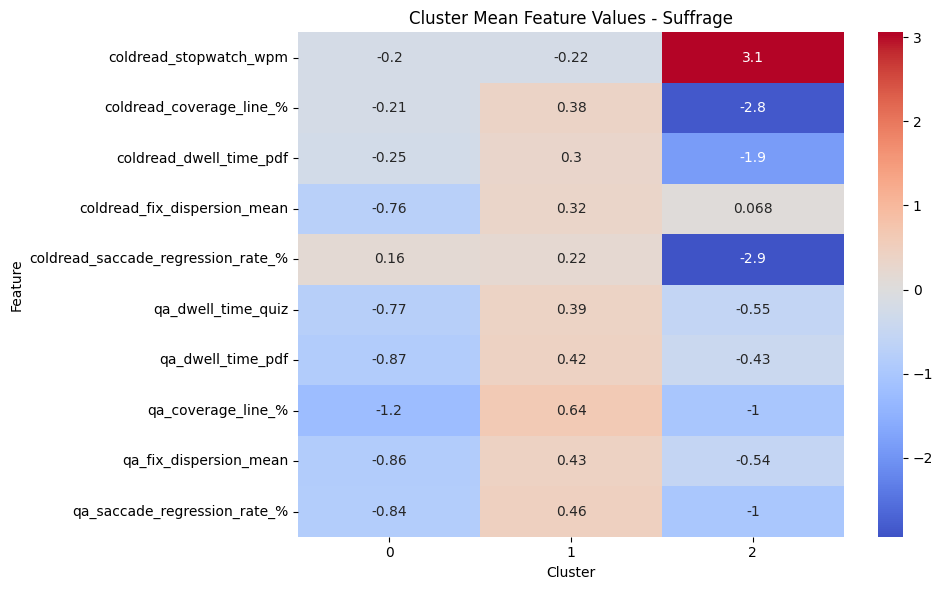


Processing assignment: GatesS...
Optimal K for GatesS: 3


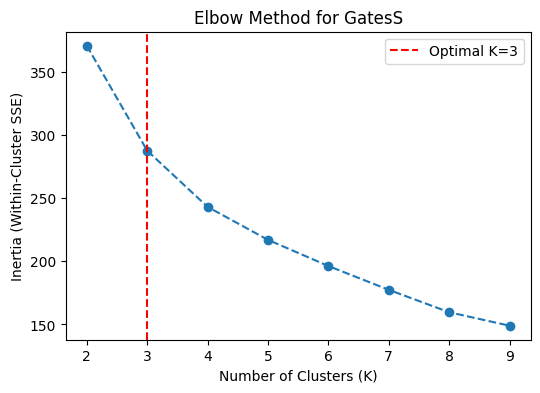

Avg Within-Cluster Variance (GatesS): 0.863
Silhouette Score (GatesS): 0.249
ANOVA Test Results for GatesS:
                                statistic       p-value
coldread_stopwatch_wpm        497.475578  6.958763e-32
qa_saccade_regression_rate_%   44.725486  1.630952e-11
qa_coverage_line_%             37.940958  1.848531e-10
qa_dwell_time_pdf              25.245218  3.983748e-08
qa_fix_dispersion_mean         17.588630  2.120504e-06


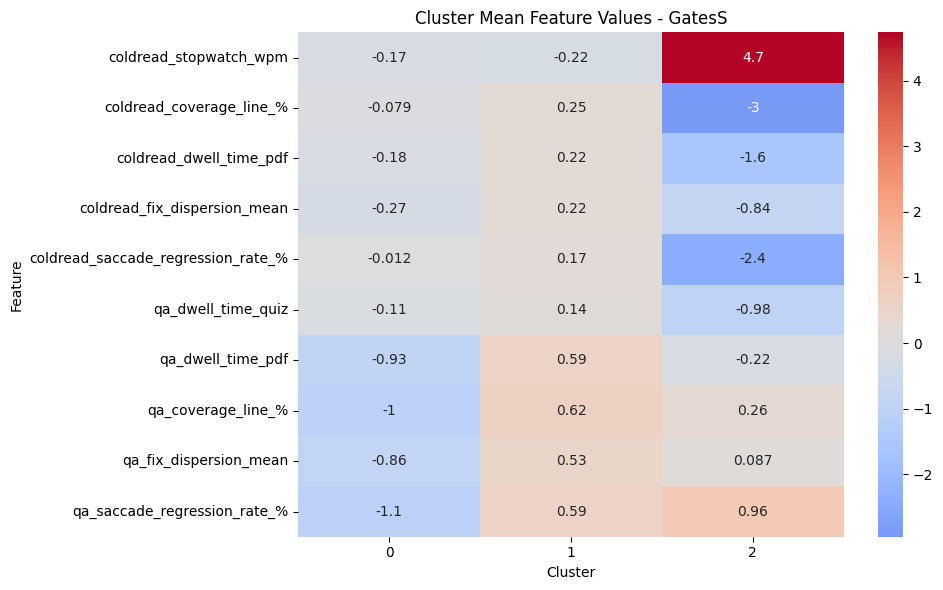


Processing assignment: GatesT...
Optimal K for GatesT: 3


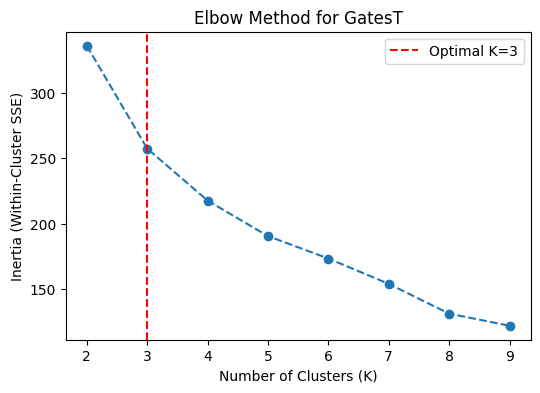

Avg Within-Cluster Variance (GatesT): 0.641
Silhouette Score (GatesT): 0.235
ANOVA Test Results for GatesT:
                                statistic       p-value
coldread_stopwatch_wpm        335.067490  1.033670e-25
qa_coverage_line_%             46.019257  4.238257e-11
qa_saccade_regression_rate_%   26.234844  5.262740e-08
coldread_fix_dispersion_mean   17.734178  3.061274e-06
qa_fix_dispersion_mean         14.588527  1.745656e-05


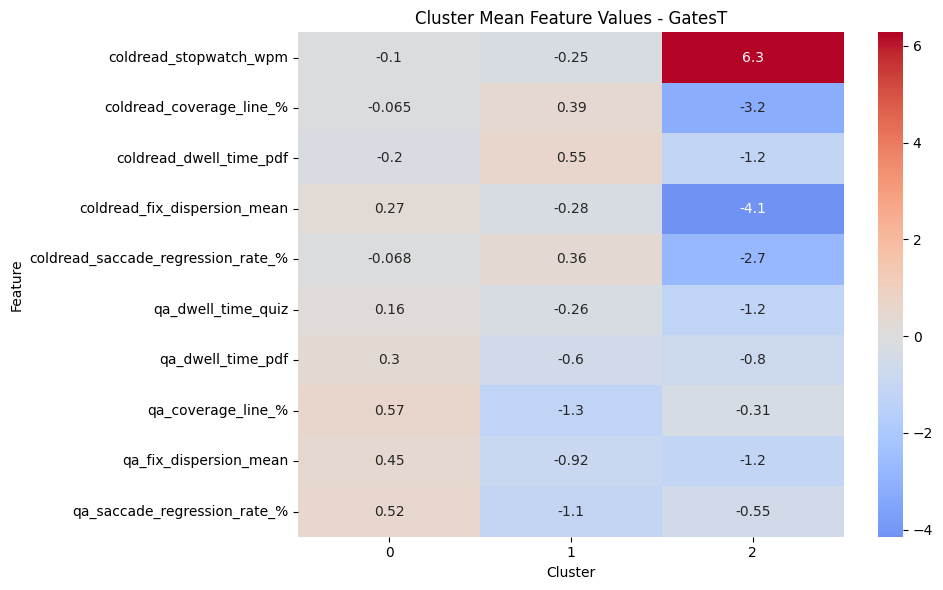

  Assignment  Optimal K  Avg Within-Cluster Variance  Silhouette Score  \
0   Suffrage          3                     0.912094          0.303904   
1     GatesS          3                     0.863175          0.248703   
2     GatesT          3                     0.640844          0.235010   

  Most Significant Feature (ANOVA) Feature P-Value  
0               qa_coverage_line_%        1.87e-14  
1           coldread_stopwatch_wpm        6.96e-32  
2           coldread_stopwatch_wpm        1.03e-25  


In [91]:
# KMeans Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Define output directories
cluster_plots_dir = CWD / 'data' / 'output' / 'cluster_kmeans'
os.makedirs(cluster_plots_dir, exist_ok=True)

cluster_metrics_results = []

for assignment_name, df in zip(assignment_names, all_dfs):
    print(f"\nProcessing assignment: {assignment_name}...")

    # Select features for clustering
    X = df[top_features].copy()

    # Standardize data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    ### 📌 Determine optimal K using the Elbow Method ###
    inertia = []
    K_range = range(2, 10)  # Testing K from 2 to 9

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)

    # Find the "elbow" point
    optimal_k = np.argmax(np.diff(inertia, 2)) + 3  # Second derivative to find elbow
    print(f"Optimal K for {assignment_name}: {optimal_k}")

    # Plot Elbow Method
    plt.figure(figsize=(6, 4))
    plt.plot(K_range, inertia, marker="o", linestyle="--")
    plt.axvline(optimal_k, color="r", linestyle="--", label=f"Optimal K={optimal_k}")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Inertia (Within-Cluster SSE)")
    plt.title(f"Elbow Method for {assignment_name}")
    plt.legend()
    plt.savefig(str(cluster_plots_dir / f"{assignment_name}_elbow.png"))
    plt.show()

    ### 📌 Run K-Means clustering with optimal K ###
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    clusters_kmeans = kmeans.fit_predict(X_scaled)
    df["kmeans_cluster"] = clusters_kmeans

    # Compute within-cluster variance on standardized data
    X_scaled_df = pd.DataFrame(X_scaled, columns=top_features)
    X_scaled_df["cluster"] = clusters_kmeans

    # Compute within-cluster variance
    # cluster_variances = df.groupby("cluster")[top_features].var()
    # avg_within_cluster_variance = cluster_variances.mean().mean()
    cluster_variance = X_scaled_df.groupby("cluster")[top_features].var()
    avg_within_cluster_variance = cluster_variance.mean().mean()
    print(f"Avg Within-Cluster Variance ({assignment_name}): {avg_within_cluster_variance:.3f}")

    # Compute silhouette score
    sil_score = silhouette_score(X_scaled, clusters_kmeans)
    print(f"Silhouette Score ({assignment_name}): {sil_score:.3f}")

    ### 📌 Compute ANOVA test for cluster distinctiveness ###
    anova_results = {}
    for feature in top_features:
        cluster_data = [X_scaled_df[X_scaled_df["cluster"] == i][feature] for i in range(optimal_k)]
        stat, p_value = stats.f_oneway(*cluster_data)  # One-way ANOVA
        anova_results[feature] = {"statistic": stat, "p-value": p_value}

    # Convert ANOVA results to DataFrame and sort by p-value
    anova_df = pd.DataFrame(anova_results).T.sort_values(by="p-value")
    print(f"ANOVA Test Results for {assignment_name}:\n", anova_df.head())

    # Save clustering metrics
    cluster_metrics_results.append({
        "Assignment": assignment_name,
        "Optimal K": optimal_k,
        "Avg Within-Cluster Variance": avg_within_cluster_variance,
        "Silhouette Score": sil_score,
        "Most Significant Feature (ANOVA)": anova_df.index[0] if not anova_df.empty else "N/A",
        "Feature P-Value": anova_df.iloc[0]["p-value"] if not anova_df.empty else "N/A"
    })

    ### 📌 Plot Heatmap of Cluster Mean Feature Values ###
    cluster_summary = X_scaled_df.groupby("cluster")[top_features].mean()

    plt.figure(figsize=(10, 6))
    sns.heatmap(cluster_summary.T, cmap="coolwarm", center=0, annot=True)
    plt.title(f"Cluster Mean Feature Values - {assignment_name}")
    plt.xlabel("Cluster")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig(str(cluster_plots_dir / f"{assignment_name}_heatmap.png"))
    plt.show()

# Convert clustering metrics to DataFrame
cluster_metrics_df = pd.DataFrame(cluster_metrics_results)
cluster_metrics_df['Feature P-Value'] = cluster_metrics_df['Feature P-Value'].apply(lambda x: f"{x:.2e}" if x != "N/A" else x)

# cluster_metrics_df = cluster_metrics_df.round(3)
cluster_metrics_df.to_excel(CWD / 'data' / 'output' / 'cluster_metrics_kmeans.xlsx', index=False)
print(cluster_metrics_df.head())


In [92]:
# Load the txts data for each passage
TXT_DIR = "./data/pdfs/txt"
texts = {}
for assignment_name in assignment_names:
    txt = open(f"{TXT_DIR}/{assignment_name}.txt", "r").read()
    texts[assignment_name] = txt

# Load the summaries of the passages
SUMMARY_DIR = "./data/pdfs/summaries"
summaries = {}
for assignment_name in assignment_names:
    txt = open(f"{SUMMARY_DIR}/{assignment_name}.txt", "r").read()
    summaries[assignment_name] = txt

# Load the questions for each passage
questions = pd.read_excel('./data/questions.xlsx', sheet_name=None)

# Load the feature descriptions (CSV)
feature_descriptions = pd.read_excel('feature_descriptions.xlsx')

# Core Reading Standards
with open('core_reading_standards.txt', 'r') as f:
    core_reading_standards = f.read()

# Load rating criteria
rating_criteria = pd.read_excel('rating_criteria.xlsx')
rating_criteria = rating_criteria.drop(columns=['Why It Matters'])

In [ ]:
# API = 'ollama'
# API = 'openai'
API = "DEBUG"
CLUSTER_METHOD = 'kmeans' # Choose from 'kmeans', 'dbscan', 'gmm', 'dendrogram', 'spectral'

if API == 'openai':
    MODEL = 'gpt-4o-mini'
    # MODEL = "gpt-4o"
    SEED = 0
elif API == 'ollama':
    MODEL = 'llama3'
    SEED = 0
else:
    MODEL = 'DEBUG'
    SEED = 0

NUM_OF_TRIALS = 5

# Define a JSON schema for the response
class ItemResponse(BaseModel):
    score: int
    justification: str

class Evaluation(BaseModel):
    Clarity: ItemResponse
    Relevance: ItemResponse
    Coherence: ItemResponse
    Actionability: ItemResponse
    Accuracy: ItemResponse
    DepthOfInsight: ItemResponse
    Specificity: ItemResponse
    Engagement: ItemResponse
    BiasAndFairness: ItemResponse
    UseOfEvidence: ItemResponse

# Define the prompt for the clasroom-wide report of an assignment
def compute_group_metrics(df, assignment_name):
    #   print(df)

    # Compute the most missed questions
    assignment_index = assignment_names.index(assignment_name)
    missed_questions = df[[f"{j+1}" for j in range(num_of_questions[assignment_index])]].mean()
    missed_questions = missed_questions.sort_values(ascending=True)

    top_5_missed_questions = missed_questions.head(5)

    metrics = {
        'count': len(df),
        'students': df['id'].values.tolist(),
        # "duration_median": round(df['total_duration'].median(), 0),
        'score_mean_%': round(df[f"score"].mean() * 100, 0),
        **{f"{feature}": round(df[f"{feature}"].mean(),2) for feature in top_features},
        'most_missed_questions_(low_means_less_correct)': {k:round(v,2) for k, v in top_5_missed_questions.items()}
    }

    # Round metrics to 2 decimal places
    metrics = {k: round(v, 2) if type(v) == float else v for k, v in metrics.items()}
    return metrics

def generate_prompt(assignment_name, df, text, summary):

    # Analyze the readability of text
    r = Readability(text)
    
    # Add information to the prompt
    ## Add ELL back
    ## Request definitions or explanations of used features and statistics
    ## Activity description

    # Compute the cluster's metrics
    cluster_metrics = {}
    for name, group in df.groupby(f'{CLUSTER_METHOD}_cluster'):
        cluster_metrics[name] = compute_group_metrics(group, assignment_name)

    # Compute the score distribution into bins
    score_distribution = df['score'].value_counts().sort_index()

    # Obtain a list of learning outcomes per student ID
    learning_outcomes = {int(k):round(v,2) for k, v in df[['id', 'score']].values}

    # Get the questions for the assignment
    q_df = questions[assignment_name]
    q_format = {}
    for i, row in q_df.iterrows():
        q_format[i+1] = row['question_text']

    # Cluster metrics as a dataframe
    cluster_metrics_df = pd.DataFrame(cluster_metrics).T

    # Construct a list of important tables
    tables = {
        'Learning Outcomes': df[['id', 'score']],
        'Score Distribution': score_distribution,
        'Cluster Statistics': cluster_metrics_df,
    }

    prompt = {
      "role": "AI Educational Analyst",
      "task": "Generate a classroom-wide report for the reading assignment based on the provided student performance data. The report should analyze trends, justify key findings, and offer actionable recommendations. Be critical, don't simply praise the students, and provide helpful insights for a teacher. Also, do not simply write out the statistics, but provide a detailed analysis and evaluation of the data.",
      "chain-of-thought": "In prelude <think></think> tags, describe your thought process as you analyze the data and generate the report. Explain how you interpret the data, what insights you gain from it, and how you use these insights to generate the report.",
      "context": {
        "assignment": {
          "title": assignment_name,
          "flesch_kincaid_grade_level": r.flesch_kincaid().grade_level,
          "flesch_kincaid_score": round(r.flesch_kincaid().score,2),
          "word_count": len(text.split()),
          "summary": summary,
          "activity": "Students were asked to read a passage without looking at the answers, this section is referred as the coldread. After they completed reading the passage, they were asked to answer a set of multiple choice questions, named the qa (question-answering) section. The questions were designed to test their comprehension of the text. The assignment was graded based on the number of correct answers.",
        },
        "targets": {
            "reading_speed": "Average reading speed for 5th grader is 120-200 words per minute.",
            "multiple_choice": "Passing score for multiple choice questions is 70%, anything below is considered failing.",
            "text_coverage": "A higher text coverage indicates better understanding of the text.",
            "reading_standards": core_reading_standards
        },
        "constraints": {
            "bias_considerations": "Ensure all student cluster descriptions are framed positively and suggest learning strategies rather than labeling deficiencies."
        },
        'feature_descriptions': feature_descriptions.to_dict(),
        'data': {
            'questions': q_format,
            'learning_outcome_distribution': {round(k,2):v for k,v in score_distribution.items()},
            'assignment_scores': learning_outcomes,
            'cluster_metrics': cluster_metrics,
            "most_missed_questions_entire_class_(low_means_less_correct)": compute_group_metrics(df, assignment_name)['most_missed_questions_(low_means_less_correct)']
        }
      },
      "output": {
        "title": f"Classroom-Wide Report: {assignment_name}",
        "items": {
            "Status": "Provide multiple status tags at the beginning of the report describing the performance of the classroom in the assignment (e.g., EXCELLENT, STRUGGLE READING, LOW ENGAGEMENT, POOR TEXT COMPREHENSION).",
            "Summary": "Provide a detailed summary of the classroom performance in the assignment, highlighting key insights and trends by referring to data. Provide concrete examples to support your analysis, such as referring to metrics. Connect to the broader curricular goals and reading standards",
            "Content": "Specify which content, based on the questions, did the students struggle with the most. Provide a detailed analysis of the most missed questions and how this relates to the students' performance.",
            "Clusters": "For the clusters, use the cluster's attributes and define names for each cluster (e.g, Careful Readers) and how this relates to their performance. Provide suggestions in how to support these clusters if they are struggling.",
            "Outliers": "Identify any outliers by providing their student ID in the classroom performance and provide an analysis of their performance. Provide suggestions on how to support these students.",
            "Recommendations": "Provide actionable recommendations for the teacher to improve the classroom performance in the assignment. These recommendations should be based on the analysis of the data and should be specific and practical. Suggest specific implementation details and measurable outcomes. Make concrete and step-by-step recommendations.",
        },
        "special_instructions": {
            "langugage": "Avoid dense language and use simple, clear, and concise language. A clearer simplification of tems and direct statements would help.",
            "description": "We have generated cluster denograms, mean cluster heatmaps, and score distribution plots for you to use in your analysis. Use the following tokens to place these plots within your response: <CLUSTER_HEATMAP>, <SCORE_DISTRIBUTION>.",
            "coherence": "Make the transitions between sections smooth and not abruptly. Ensure that the report is well-structured and easy to follow.",        
        },
        "format": "Markdown"
      }
    }
    return prompt, tables

prompt_res_table = defaultdict(list)
timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
report_dir = CWD / 'data' / 'reports' / timestamp
os.makedirs(report_dir, exist_ok=True)
for assignment_name, df in zip(assignment_names, all_dfs):
    text = texts[assignment_name]
    summary = summaries[assignment_name]
    prompt, tables = generate_prompt(assignment_name, df, text, summary)

    # Create a subdirectory for this specific assignment
    assignment_report_dir = report_dir / assignment_name
    os.makedirs(assignment_report_dir, exist_ok=True)
    
    # Save input prompt
    with open(assignment_report_dir / f"prompt.json", "w") as f:
        f.write(json.dumps(prompt, indent=4))

    # Generate the report using Ollama
    if API == 'openai':
        res = openai_client.chat.completions.create(
            model=MODEL,
            messages=[
                {
                    "role": "user",
                    "content": json.dumps(prompt)
                }
            ]
        )
        content = res.choices[0].message.content
    elif API == 'ollama':
        res = ollama.chat(
            model=MODEL,
            messages=[
                {
                    "role": "user",
                    "content": json.dumps(prompt)
                }
            ],
            options={
                "seed": SEED,
                "temperature": 0
            }
        )
        content = res['message']['content']
    else:
        content = "DEBUG"

    # Create directory for evaluation
    eval_dir = assignment_report_dir / f"llm_evaluation"
    os.makedirs(eval_dir, exist_ok=True)

    # Evaluate the response with Ollama
    eval_prompt = {
        "role": "Educator",
        "task": "Evaluate the generated classroom-wide report using a 1-5 Likert scale (5 = Excellent, 1 = Poor). Be brutally honest and nitpick aspects of the report that could be better. Provide a rating and a justification for each of the following criteria: clarity, relevance, coherence, and actionability. Respond only with valid JSON. Do not write a summary or introduction.",
        "additional_details": {
            "target_audience": "Teachers, educators, and reading experts",
        },
        "evaluation_criteria": rating_criteria.to_dict(),
        "original_prompt": prompt,
        "generated_report": content,
    }

    # Save evaluation prompt
    with open(eval_dir / f"eval_prompt.json", "w") as f:
        f.write(json.dumps(eval_prompt, indent=4))

    eval_responses = defaultdict(list)
    for i in range(NUM_OF_TRIALS):
        if API == 'openai':
            res = openai_client.beta.chat.completions.parse(
                model=MODEL,
                messages=[
                    {
                        "role": "user",
                        "content": json.dumps(eval_prompt)
                    }
                ],
                response_format=Evaluation
            )
            # eval_content = res.choices[0].message.content
            eval_content = res.choices[0].message.parsed
        elif API == 'ollama':
            eval_res = ollama.chat(
                model=MODEL,
                format=Evaluation.model_json_schema(),
                messages=[
                    {
                        "role": "user",
                        "content": json.dumps(eval_prompt)
                    }
                ],
                options={
                    "seed": SEED,
                    "temperature": 0
                }
            )
            eval_content = Evaluation.model_validate_json(eval_res['message']['content'])
        else:
            eval_content = Evaluation(
                Clarity=ItemResponse(score=random.randint(1,5), justification="DEBUG"),
                Relevance=ItemResponse(score=random.randint(1,5), justification="DEBUG"),
                Coherence=ItemResponse(score=random.randint(1,5), justification="DEBUG"),
                Actionability=ItemResponse(score=random.randint(1,5), justification="DEBUG"),
                Accuracy=ItemResponse(score=random.randint(1,5), justification="DEBUG"),
                DepthOfInsight=ItemResponse(score=random.randint(1,5), justification="DEBUG"),
                Specificity=ItemResponse(score=random.randint(1,5), justification="DEBUG"),
                Engagement=ItemResponse(score=random.randint(1,5), justification="DEBUG"),
                BiasAndFairness=ItemResponse(score=random.randint(1,5), justification="DEBUG"),
                UseOfEvidence=ItemResponse(score=random.randint(1,5), justification="DEBUG")
            )
        
        # Save eval into .json
        with open(eval_dir / f"eval_{i}.json", "w") as f:
            f.write(json.dumps(eval_content.dict(), indent=4))

        # Accumulate the results into a table
        eval_responses['clarity'].append(eval_content.Clarity.score)
        eval_responses['relevance'].append(eval_content.Relevance.score)
        eval_responses['coherence'].append(eval_content.Coherence.score)
        eval_responses['actionability'].append(eval_content.Actionability.score)
        eval_responses['accuracy'].append(eval_content.Accuracy.score)
        eval_responses['depth_of_insight'].append(eval_content.DepthOfInsight.score)
        eval_responses['specificity'].append(eval_content.Specificity.score)
        eval_responses['engagement'].append(eval_content.Engagement.score)
        eval_responses['bias_and_fairness'].append(eval_content.BiasAndFairness.score)
        eval_responses['use_of_evidence'].append(eval_content.UseOfEvidence.score)

    # Save the table of responses
    eval_df = pd.DataFrame(eval_responses)
    eval_df.to_excel(eval_dir / "evaluations.xlsx", index=False)

    # Remove the what's ever between <think> and </think> tags
    content = content.split("<think>")[0] + content.split("</think>")[-1]

    # Save the table in the same directory
    for table_name, table in tables.items():
        table.to_excel(assignment_report_dir / f"{table_name}.xlsx", index=False)

    # Save the raw table
    df.to_excel(assignment_report_dir / f"raw_data_table.xlsx", index=False)
    
    # Add the figures into the content of the report
    if '<SCORE_DISTRIBUTION>' in content:
        content = content.replace("<SCORE_DISTRIBUTION>", f"![Score Distribution](data/output/score_distribution/{assignment_name}.png)")
    else:
        content += f"\n\n![Score Distribution](data/output/score_distribution/{assignment_name}.png)"
    if '<CLUSTER_HEATMAP>' in content:
        content = content.replace("<CLUSTER_HEATMAP>", f"![Cluster Heatmap](data/output/cluster_{CLUSTER_METHOD}/{assignment_name}_heatmap.png)")
    else: # Append it to the end
        content += f"\n\n![Cluster Heatmap](data/output/cluster_mean_heatmaps/{assignment_name}.png)"

    # Write into a markdown file
    with open(assignment_report_dir / f"{assignment_name}.md", "w") as f:
        f.write(content)

    # If pandoc is installed, convert the markdown to pdf
    try:
        os.system(f"pandoc {assignment_report_dir / f'{assignment_name}.md'} -o {assignment_report_dir / f'{assignment_name}.pdf'}")
    except:
        print("Pandoc not installed. Skipping PDF generation.")

    # Store the results in a table
    prompt_res_table['assignment'].append(assignment_name)
    prompt_res_table['prompt'].append(prompt)
    prompt_res_table['response'].append(content)
    prompt_res_table['evaluation'].append(eval_content)
    # break

# Save the results into a table
prompt_res_df = pd.DataFrame(prompt_res_table)
prompt_res_df.to_excel(report_dir / "complete_table.xlsx", index=False)

# Write meta data stating which model was used
with open(report_dir / "meta.json", "w") as f:
    # f.write(f"Model: {MODEL}\nSeed: {SEED}\nAPI: {API}")
    json.dump({
        'model': MODEL,
        'seed': SEED,
        'api': API
    }, f, indent=4)

/tmp/ipykernel_1446325/2742127749.py:262: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  f.write(json.dumps(eval_content.dict(), indent=4))
